In [1]:
%matplotlib inline
import os,sys
import matplotlib
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import csv
import pandas as pd
import sfdmap
import extinction
from astropy import units as u
import math
import pylatex

# pyqsofit
from scipy import interpolate

# for SDSS SQL queries
import mechanize
from io import BytesIO

import glob,timeit

#sys.path.append('/Users/runnojc1/Software/py/pyspeckit')
import pyspeckit
from pyspeckit.spectrum.models.inherited_gaussfitter import gaussian
from pyspeckit.specwarnings import PyspeckitWarning
from astropy.table import Table

# Data

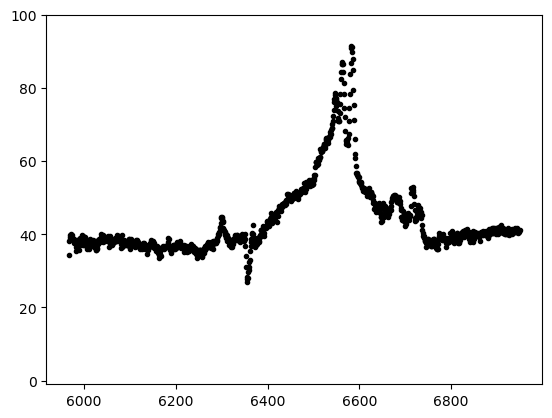

In [4]:
file_path = 'HET/combined_spectrum_20230113_0000022_exp01.fits'

t = Table.read(file_path)
t.sort('Wavelength')

z = 0.081
wl = t['Wavelength']/(1+z)
flux = t['F_lambda'] * (10**17)
err = t['e_F_lambda']

flux_lim = np.where(flux>0)[0]
wl=wl[flux_lim]
flux=flux[flux_lim]
err=err[flux_lim]

wl_lim = np.where((wl>5900)&(wl<6950))
wl=wl[wl_lim]
flux=flux[wl_lim]
err=err[wl_lim]

#mask1 = np.where((wl<6320)|(wl>6370))
#wl=wl[mask1]
#flux=flux[mask1]
#err=err[mask1]

plt.plot(wl, flux, '.k')
#plt.xlim(5500, 7500)
plt.ylim(-1, 100)
plt.show()

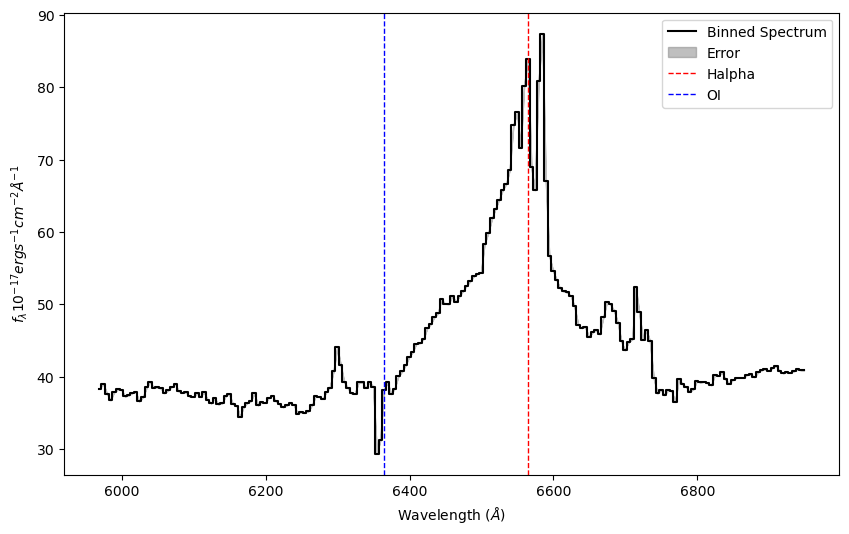

In [5]:
bin_width = 5

bins = np.arange(min(wl), max(wl) + bin_width, bin_width)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

indices = np.digitize(wl, bins)

binned_wl = []
binned_flux = []
binned_flux_err = []


for i in range(1, len(bins)):
    in_bin = indices == i
    if np.any(in_bin):
        binned_wl.append(np.mean(wl[in_bin]))
        binned_flux.append(np.mean(flux[in_bin]))
        binned_flux_err.append(np.mean(err[in_bin]))
    else:
        pass

binned_wl = np.array(binned_wl)
binned_flux = np.array(binned_flux)
binned_flux_err = np.array(binned_flux_err)

plt.figure(figsize=(10, 6))
plt.plot(binned_wl, binned_flux, label='Binned Spectrum', color="black", drawstyle='steps-mid')
plt.fill_between(binned_wl, binned_flux - binned_flux_err, binned_flux + binned_flux_err, color='gray', alpha=0.5, label='Error')
plt.axvline(x=6564.93, color='r', linestyle='--', linewidth=1, label="Halpha")
plt.axvline(x=6365, color='b', linestyle='--', linewidth=1, label="OI")
plt.xlabel("Wavelength ($\AA$)")
plt.ylabel("$f_{\lambda} 10^{-17} erg s^{-1} cm^{-2} \AA^{-1}$")
#plt.xlim(5900, 6900)
#plt.ylim(0, 100)
plt.legend()
plt.show()

## Functions

In [ ]:
def kms_to_ang(dv,w0):
    """
    Convert a width in km/s to A.
    """
    c = 2.99792458e5 # km/s
    dlam = (dv/c)*w0
    return dlam

In [5]:
def powerlaw(x, scale, power):
    """
    Defines a power law

    Returns
    -------
    scale * x**power
    """
    return scale*(x/1000.)**-power

In [6]:
def gaussian(xarr,amplitude,cent,fwhm,normalized=False,return_components=False,return_hyperfine_components=False):
    """
    Returns a 1-dimensional gaussian of form
    A*np.exp(-(x-dx)**2/(2*w**2))

    Area is sqrt(2*pi*sigma^2)*amplitude - i.e., this is NOT a normalized
    gaussian, unless normalized=True in which case A = Area
    
    Parameters
    ----------
    xarr : np.ndarray
        array of x values
    amplitude : float
        Amplitude of the Gaussian, i.e. its peak value, unless
        normalized=True then A is the area of the gaussian
    cent : float
        Center or "shift" of the gaussian same units as xarr
    fwhm : float
        Full width at half maximum of the Gaussian in km/s
    return_components : bool
        dummy variable; return_components does nothing but is required by all
        fitters
    return_hyperfine_components : bool
        dummy variable; does nothing but is required by all
        fitters
    normalized : bool
        Return a normalized Gaussian?
    """ 
    fwhm = kms_to_ang(fwhm,cent)
    if fwhm == 0:
        return np.nan
    elif fwhm < 0:
        warnings.warn("Negative width in Gaussian: {0}.".format(width),
                      PyspeckitWarning)

    width = fwhm/np.sqrt(8*np.log(2))
    xarr = np.array(xarr) # make sure xarr is no longer a spectroscopic axis
    model = amplitude*np.exp(-(xarr-cent)**2/(2.0*width**2))
    if normalized:
        return model / (np.sqrt(2*np.pi) * width**2)
    else:
        return model

In [7]:
def optical_agn_spectrum(wave_to_fit,pl_s,pl_e,\
                         sii1_f,sii1_cent,sii1_fwhm,\
                         return_components=False,return_hyperfine_components=False):
    """
    Calculates a full optical AGN spectral model.
    """
    
    #x = wave_to_fit.to_value()
    x = np.array(wave_to_fit)
    y = np.zeros_like(x)
    
    # powerlaw
    pl = powerlaw(x,pl_s,pl_e)  
    
    #optical s II template
    #sii = template_fitter(x,feii_templates,fe_s,fe_index,fe_shift)
    
    # MILES stellar template
    #sb = template_fitter(x,stellar_templates,sb_s,sb_index,sb_shift)
    
    # balmer continuum
    #bc = template_fitter(x,balmer_cont_templates,bc_s,bc_index,bc_shift)
    
    # high-order Balmers lines (n=8+)
    #ho = template_fitter(x,balmer_highorder_templates,bh_s,bh_index,bh_shift)
    
    # [O III] 5007
    #o3l1 = gaussian(x,o3l1_f,o3l1_cent,o3l1_fwhm,normalized=False)
    #o3l2 = gaussian(x,o3l2_f,o3l2_cent,o3l2_fwhm,normalized=False)
    
    # [O III] 4959
    #o3s1 = gaussian(x,o3s1_f,o3s1_cent,o3s1_fwhm,normalized=False)
    #o3s2 = gaussian(x,o3s2_f,o3s2_cent,o3s2_fwhm,normalized=False)  
    
    # narrow Hbeta
    #hbn1 = gaussian(x,hbn1_f,hbn1_cent,hbn1_fwhm,normalized=False)
    #hbn2 = gaussian(x,hbn2_f,hbn2_cent,hbn2_fwhm,normalized=False)  
    
    # broad Hbeta
    #hbb1 = gaussian(x,hbb1_f,hbb1_cent,hbb1_fwhm,normalized=False)      
    #hbb2 = gaussian(x,hbb2_f,hbb2_cent,hbb2_fwhm,normalized=False) 
    #hbb3 = gaussian(x,hbb3_f,hbb3_cent,hbb3_fwhm,normalized=False) 
    
    # broad Hgamma
    #hgb1 = gaussian(x,hgb1_f,hgb1_cent,hgb1_fwhm,normalized=False)      
    #hgb2 = gaussian(x,hgb2_f,hgb2_cent,hgb2_fwhm,normalized=False) 
    
    # broad Hdelta
    #hdb1 = gaussian(x,hdb1_f,hdb1_cent,hdb1_fwhm,normalized=False)
    #hdb2 = gaussian(x,hdb2_f,hdb2_cent,hdb2_fwhm,normalized=False)
    
    # broad Hepsilon
    #heb1 = gaussian(x,heb1_f,heb1_cent,heb1_fwhm,normalized=False)
    #heb2 = gaussian(x,heb2_f,heb2_cent,heb2_fwhm,normalized=False)
    
    # narrow [S II] 4072
    #s21 = gaussian(x,s21_f,s21_cent,s21_fwhm,normalized=False)
    #s22 = gaussian(x,s22_f,s22_cent,s22_fwhm,normalized=False)
    
    # narrow [Ne III] 3869
    #ne3s1 = gaussian(x,ne3s1_f,ne3s1_cent,ne3s1_fwhm,normalized=False)
    #ne3s2 = gaussian(x,ne3s2_f,ne3s2_cent,ne3s2_fwhm,normalized=False)
    
    # narrow [Ne III] 3967
    #ne3l1 = gaussian(x,ne3l1_f,ne3l1_cent,ne3l1_fwhm,normalized=False)
    #ne3l2 = gaussian(x,ne3l2_f,ne3l2_cent,ne3l2_fwhm,normalized=False)
    
    # narrow [O II] 3726
    #o2s1 = gaussian(x,o2s1_f,o2s1_cent,o2s1_fwhm,normalized=False)
    #o2s2 = gaussian(x,o2s2_f,o2s2_cent,o2s2_fwhm,normalized=False)
    
    # narrow [O II] 3729
    #o2l1 = gaussian(x,o2l1_f,o2l1_cent,o2l1_fwhm,normalized=False)
    #o2l2 = gaussian(x,o2l2_f,o2l2_cent,o2l2_fwhm,normalized=False)
    
    # narrow [Ne V] 3346
    #ne5s1 = gaussian(x,ne5s1_f,ne5s1_cent,ne5s1_fwhm,normalized=False)
    #ne5s2 = gaussian(x,ne5s2_f,ne5s2_cent,ne5s2_fwhm,normalized=False)
    
    # broad [S II] - 6718.85 & 6733.72
    sii1 = gaussian(x,sii1_f,sii1_cent,sii1_fwhm,normalized=False)
    #ne5l2 = gaussian(x,ne5l2_f,ne5l2_cent,ne5l2_fwhm,normalized=False)    

    y = pl + sii1
    
    if return_components:
        y = {'model':y,\
             'pl':pl,\
            'sii1':sii1} 
    
    return y

In [8]:
def pl_fitter(order=1):
    """
    Generator for powerlaw fitter class
    """

    myclass =  pyspeckit.models.model.SpectralModel(plaw, 2,
            parnames=['scale','power'], 
            parlimited=[(False,False),(False,False)], 
            parlimits=[(0,0),(0,0)], 
            shortvarnames=('S','P')
            )
    myclass.__name__ = "pl"
    
    return myclass

In [9]:
def template_fitter(wave,templates,scale_factor,index,shift):
    '''
    given a series of templates (like stellar models by age or Fe II templates by convolution width),
    returns a spectrum interpolated between template spectra and scaled.
    Spectrum is also interpolated onto the wavelength vector of the observed data.
    
    params:
        wave - wavelength vector of observed data
        templates - 2D numpy array of shape (numpoints,num_templates+1), where 1st column is wavelength, subsequent columns are templates
        index - selected index within templates [0-num_templates]. Float, will interpolate between templates when index!=int
        scale_factor - multiplicative scale factor for spectrum
    '''
    num_templates=templates.shape[1]-1
    numpoints=templates.shape[0]
    
    if shift>=0:
        wave_temp=templates[:,0]*(1+shift)
    else:
        wave_temp=templates[:,0]/(1+shift)
    flux_temp=templates[:,1:]
    
    # Perform interpolation between templates
    if index==num_templates-1:
        spectrum=templates[:,-1]
    else:
        lower_idx=int(math.floor(index)+1) #+1 because 0th index is wavelength column
        lower_spectrum=templates[:,lower_idx] # this means lower in index, not necessarily in flux
        
        upper_idx=lower_idx+1
        upper_spectrum=templates[:,upper_idx]
        
        weight=(index+1)-lower_idx #1=choose upper spectrum value, 0=choose lower spectrum value, 0.5=choose midpoint
        
        distances=upper_spectrum-lower_spectrum # array of distances between selected spectra
        
        spectrum=lower_spectrum+(weight*distances)
        
    # Perform scaling
    scaled_spectrum=spectrum*scale_factor
    
    # interpolate spectrum onto wavelength vector of data
    final_spectrum=np.interp(wave,wave_temp,scaled_spectrum)

    return final_spectrum

In [10]:
def optical_agn_fitter(order=1):
    """
    Generator for powerlaw fitter class
    """

    myclass =  pyspeckit.models.model.SpectralModel(optical_agn_spectrum, 5,
            parnames=['pl_s','pl_e',\
                     'sii1_f','sii1_cent','sii1_fwhm'], 
            parlimited=[(False,False),(False,False),\
                       (False,False),(False,False),(False,False)], 
            parlimits=[(0,0),(0,0),\
                      (0,0),(0,0),(0,0)]
            )
    myclass.__name__ = "optagn"
    
    return myclass

In [11]:
def plot_optical_agn_fit(wave,flux,model,wavemin,wavemax,ymin,ymax,xlabel,ylabel,plotfile,HARDCOPY=False,SHOW=True):
    
    sii1 = model['sii1']
    
    
    fig = plt.figure(figsize=(18, 6))
    ax  = plt.axes()
    ax.plot(wave,flux,drawstyle='steps-mid',color='black')
    ax.plot(wave,model['model'],color=indian_red,lw=2)
    ax.plot(wave,model['pl'],color=royal_blue)
    ax.plot(wave,sii1,color=pink)
    ax.set_xlim(wavemin,wavemax)
    ax.set_ylim(ymin,ymax)
    ax.set_xlabel(xlabel,size=24)
    ax.set_ylabel(ylabel,size=24)
    plt.tight_layout()
    if HARDCOPY: fig.savefig(plotfile+'_fullfit.pdf', format='pdf')
    if SHOW: plt.show()
    plt.close(fig)
    
    #fig = plt.figure(figsize=(8, 6))
    #ax  = plt.axes()
    #ax.plot(wave,flux,drawstyle='steps-mid',color='black')
    #ax.plot(wave,model['model'],color=indian_red,lw=2)
    #ax.plot(wave,model['pl'],color=royal_blue)
    #ax.set_xlim(4700,5100)
    #ax.set_ylim(ymin,ymax)
    #ax.set_xlabel(xlabel,size=24)
    #ax.set_ylabel(ylabel,size=24)
    #plt.tight_layout()  
    #if HARDCOPY: fig.savefig(plotfile+'_Hbfit.pdf', format='pdf')
    #if SHOW: plt.show()
    #plt.close(fig)
    #
    #fig = plt.figure(figsize=(8, 6))
    #ax  = plt.axes()
    #ax.plot(wave,flux,drawstyle='steps-mid',color='black')
    #ax.plot(wave,model['model'],color=indian_red,lw=2)
    #ax.plot(wave,model['pl'],color=royal_blue)
    #ax.set_xlim(3715,4450)
    #ax.set_ylim(ymin,ymax)
    #ax.set_xlabel(xlabel,size=24)
    #ax.set_ylabel(ylabel,size=24)
    #plt.tight_layout()  
    #if HARDCOPY: fig.savefig(plotfile+'_SBfit.pdf', format='pdf')
    #if SHOW: plt.show()
    #plt.close(fig)

## Setup for plotting

In [12]:
# SETUP 
##############################################################
##############################################################
fontfamily = 'Times New Roman'
matplotlib.rcParams['font.family'] = fontfamily
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']=r"\usepackage{amsmath}"
plt.rc('xtick.major',pad=2)
plt.rc('ytick.major',pad=2)
plt.rc('xtick.minor',pad=2)
plt.rc('ytick.minor',pad=2)
plt.rc('xtick', labelsize=24)
plt.rc('ytick', labelsize=24)
plt.rc('font',size=24,weight='bold')
plt.rcParams['axes.labelweight'] = 'bold'

blood_orange = [204/255,17/255,0/255]
indian_red = [176/255,23/255,31/255]
indian_red = [200/255,23/255,31/255]
green = [0/255,205/255,0/255]
dark_orange = [255/255,127/255,0/255]
goldenrod = [255/255,193/255,37/255]
midnight_blue = [25/255,25/255,112/255]
transparent_blue = [138/255,181/255,220/255]
gray = [130/255,130/255,130/255]
dark_gray = [50/255,50/255,50/255]
salmon = [250/255,128/255,114/255]
royal_blue = [0/255,0/255,200/255]
turquoise  = [0/255,204/255,204/255]
cyan  = [0/255,255/255,255/255]
pink = [255/255,0/255,127/255]
med_pink = [191/255, 0/255, 96/255]
dark_pink = [128/255, 0/255, 64/255]

## Set up emission lines

This sets emission lines and some offsets between them.

In [13]:
# set up the relevant emission lines
#Hbeta = 4862.721
#OIIIa = 4960.295
#OIIIb = 5008.239
#Hgamma = 4341.68
#Hdelta = 4102.0
#Hepsilon = 3971.
#SII    = 4072.
#NeIIIa = 3869.
#NeIIIb = 3967.
#OIIa   = 3726.
#OIIb   = 3729.
#NeVa   = 3346.
#NeVb   = 3425.
#
#OIIIa_off    = OIIIa/OIIIb
#Hbeta_off    = Hbeta/OIIIb
#SII_off      = SII/OIIIb
#NeIIIa_off   = NeIIIa/OIIIb
#NeIIIb_off   = NeIIIb/OIIIb
#OIIa_off     = OIIa/OIIIb
#OIIb_off     = OIIb/OIIIb
#NeVa_off     = NeVa/OIIIb
#NeVb_off     = NeVb/OIIIb
#Hepsilon_off = Hepsilon/Hdelta
#
c = 2.99e5 # km/s

## Fit parameters from a rough spectral decomposition

Do a very rough spectral decomposition to the H$\beta$ region in order to get some guesses for starting parameters in this regime.

This creates a "continuum subtracted" spectrum by subtracting a hardcoded value, then fits Gaussians and saves their best-fit values to use as a starting guess later. It won't work on any other spectrum because of the continuum subtraction.

In [14]:
# starting guesses
#broad_amp       = 100.
#broad_sigma_kms = 11000.
#broad_sigma     = (broad_sigma_kms/c)*Hbeta
#narrow_sigma_kms = 800.
#narrow_sigma     = (narrow_sigma_kms/c)*Hbeta
#broad_fwhm = 3000.
#narrow_fwhm = 800.

#use = np.where((lam>6000) & (lam<7000))[0]


flux_unit = u.erg / (u.s * u.cm**2 * u.AA)
wavelength_unit = u.AA 
error_unit = flux_unit  

flux = binned_flux
lam = binned_wl
err = binned_flux_err

print(flux)


#
#spec = pyspeckit.Spectrum(data=flux,xarr=lam, error=err)
#spec.unit = 'erg s$^{-1}$ cm$^{-2}$ $\\AA^{-1}$'
#spec.xarr.set_unit = u.angstrom #'$\\AA$'
#spec.xarr.xtype='angstrom'



[37.62736982 37.35852415 37.82325117 37.79102206 36.93823744 36.7882756
 38.3182901  39.53393461 38.27345799 38.71964851 38.27452039 38.05106807
 37.9058877  38.62811376 38.76835446 38.24001436 37.7436757  37.94370117
 37.35339591 37.32921855 37.5310545  37.27949965 37.75496692 37.17747812
 36.32922414 36.88636085 36.58306285 36.03404401 36.95671775 37.79434785
 36.57456527 36.1421033  34.7948349  35.50818524 36.38950595 36.58532893
 37.73809162 36.13469075 36.56274735 36.24883377 37.08473517 37.49987469
 36.48626111 36.2230004  35.91627741 36.07826676 36.3051456  36.12122566
 35.04125966 35.27732709 35.11315873 34.9680708  35.94890143 37.05860421
 37.38551458 36.78065869 37.86262454 38.30634576 40.3515994  43.8539908
 42.14092897 39.56986243 38.57660089 37.951722   37.80036985 37.54445032
 38.54852254 39.46544579 41.03801908 41.05733534 42.64994371 43.04806009
 44.64871201 44.46821057 45.1788493  46.53736572 47.13807164 48.00647873
 48.67561598 50.43093527 50.36264259 49.90407059 50.8

In [15]:
sii1 = 6718.85

In [16]:
guesses = [5,0,\
          10, sii1, 1000]
           
tied = ['','',\
       '', '', '']

step = [0.5, 0.05,\
       0.5, 0.1, 5]

fixed = [0,0,\
        0,0,0]

In [17]:
print(len(guesses))

5


In [18]:
# this actually does the fit after resetting the spectrum
spec = pyspeckit.Spectrum(data=flux,xarr=lam,error=err)
spec.unit = 'erg s$^{-1}$ cm$^{-2}$ $\\AA^{-1}$'
spec.xarr.set_unit = u.angstrom #'$\\AA$'
spec.xarr.xtype='angstrom'
spec.Registry.add_fitter('opticalagn',optical_agn_fitter(),5)
spec.specfit.selectregion(xmin=6000,xmax=7000)
spec.specfit(fittype='opticalagn',vheight=False,guesses=guesses,tied=tied,fixed=fixed,parsteps=step,maxiter=500,baseline=False,subtract_baseline=False,quiet=False)

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,191 [pyspeckit.spectrum.interactive]
Iter       1    CHI-SQUARE =  7.351361955e+39  DOF =  186
   PL_S0 = 5  
   PL_E0 = 0  
   SII1_F0 = 10  
   SII1_CENT0 = 6718.85  
   SII1_FWHM0 = 1000  
Iter       2    CHI-SQUARE =  1.834337125e+39  DOF =  186
   PL_S0 = 9.667168934  
   PL_E0 = -0.520742844  
   SII1_F0 = 14.48616679  
   SII1_CENT0 = 6718.585305  
   SII1_FWHM0 = 1669.171977  
Iter       3    CHI-SQUARE =  7.475285432e+38  DOF =  186
   PL_S0 = 11.60901171  
   PL_E0 = -0.8018287839  
   SII1_F0 = 4.067310256  
   SII1_CENT0 = 6712.526335  
   SII1_FWHM0 = 1036.973456  
Iter       4    CHI-SQUARE =  3.885661292e+38  DOF =  186
   PL_S0 = 12.35090136  
   PL_E0 = -0.6737070911  
   SII1_F0 = 3.908667093  
   SII1_CENT0 = 6716.671388  
   SII1_FWHM0 = 789.9961574  
Iter       5    CHI-SQUARE =  3.884402509e+38  DOF =  186
   PL_S0 = 12.775233  
   PL_E0 = -0.6532750997  
   SII1_F0 = 5.788777172  
   SII1_CENT0 = 6716.05

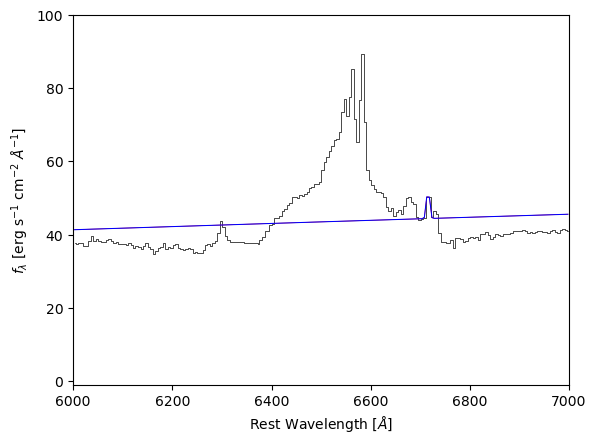

In [19]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
spec.plotter(xmin=6000,xmax=7000,ymin=-1,ymax=100,xlabel='Rest Wavelength [$\AA$]',ylabel="$f_{\lambda}$ [erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]")
spec.specfit.plot_fit(annotate=False)
spec.specfit.plot_components()
plt.show()

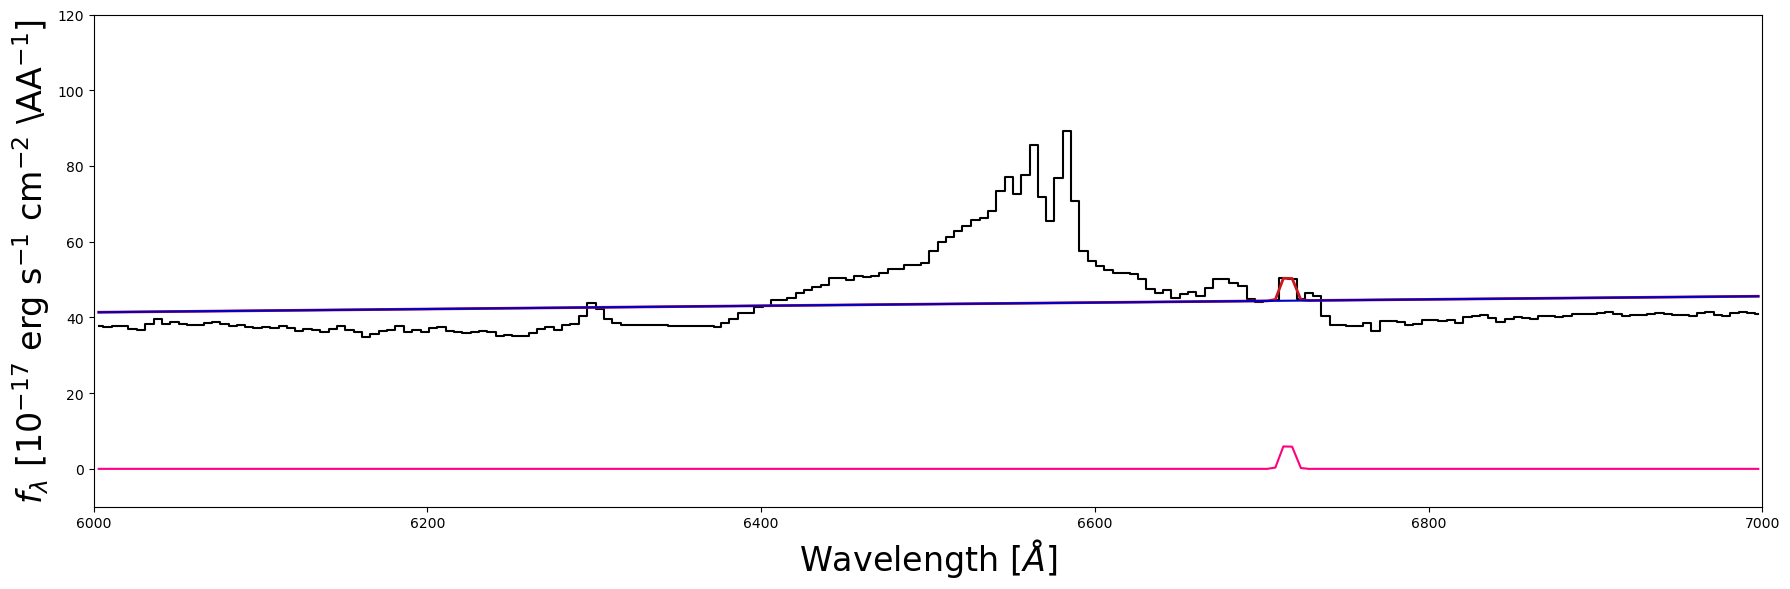

In [20]:
best_model = optical_agn_spectrum(lam,*spec.specfit.parinfo.values,return_components=True)
wavemin = 1000.
wavemax = 1650.
ymin = -100.
ymax = 400.
wave = lam
flux = flux
model = best_model
xlabel = 'Wavelength $[\AA]$'
ylabel = '$f_\lambda$ [10$^{-17}$ erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$]'
plotfile = '../plots/j0950/plots/spec-52509-0902-0498'
HARDCOPY = False
SHOW = True

plot_optical_agn_fit(lam,flux,best_model,6000,7000,-10,120,'Wavelength $[\AA]$',\
                     '$f_\lambda$ [10$^{-17}$ erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$]',\
                     plotfile,HARDCOPY=False,SHOW=True)

In [56]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
spec.plotter(xmin=4700,xmax=5200,ymin=0,ymax=100,xlabel='Rest Wavelength [$\AA$]',ylabel="$f_{\lambda}$ [erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]")
spec.specfit.plot_fit(annotate=False)
spec.specfit.plot_components()
plt.show()

Exception: Infinite recursion error.  Maybe there are no valid data?

In [24]:
# check for any very small values (e.g., WIDTH8 was fitting to 1d-14 and then being used as an initial guess later)
spec.specfit.parinfo

[Param #0   AMPLITUDE0 =      54.0959 +/-     6.26736e+08   Range:   [0,inf),
 Param #1       SHIFT0 =      5007.37 +/-      1.9425e+07 ,
 Param #2       WIDTH0 =      3.28781 +/-     2.71789e+07   Range:   [0,inf),
 Param #3   AMPLITUDE1 =      15.7098 +/-      5.9652e+08   Range:   [0,inf),
 Param #4       SHIFT1 =      5003.69 +/-     1.74022e+08 ,
 Param #5       WIDTH1 =      6.87398 +/-     9.64351e+07   Range:   [0,inf),
 Param #6   AMPLITUDE2 =       18.032 +/-               0   Range:   [0,inf) Tied: p[0]/3,
 Param #7       SHIFT2 =      4959.43 +/-               0  Tied: p[1] * 0.9904269744315318,
 Param #8       WIDTH2 =      3.28781 +/-               0   Range:   [0,inf) Tied: p[2],
 Param #9   AMPLITUDE3 =       5.2366 +/-               0   Range:   [0,inf) Tied: p[3]/3,
 Param #10       SHIFT3 =      4955.79 +/-               0  Tied: p[4] * 0.9904269744315318,
 Param #11       WIDTH3 =      6.87398 +/-               0   Range:   [0,inf) Tied: p[5],
 Param #12   AMPLITUDE

In [25]:
# save the best-fit values for the Gaussians in the H-beta region
o3l1amp   = spec.specfit.parinfo.AMPLITUDE0.value
o3l2amp   = spec.specfit.parinfo.AMPLITUDE1.value
o3l1cent  = spec.specfit.parinfo.SHIFT0.value
o3l2cent  = spec.specfit.parinfo.SHIFT1.value
o3l1width = (spec.specfit.parinfo.WIDTH0.value/o3l1cent)*2.99e5*2.35
o3l2width = (spec.specfit.parinfo.WIDTH1.value/o3l2cent)*2.99e5*2.35

o3s1amp   = spec.specfit.parinfo.AMPLITUDE2.value
o3s2amp   = spec.specfit.parinfo.AMPLITUDE3.value
o3s1cent  = spec.specfit.parinfo.SHIFT2.value
o3s2cent  = spec.specfit.parinfo.SHIFT3.value
o3s1width = (spec.specfit.parinfo.WIDTH2.value/o3s1cent)*2.99e5*2.35
o3s2width = (spec.specfit.parinfo.WIDTH3.value/o3s2cent)*2.99e5*2.35

hbn1amp   = spec.specfit.parinfo.AMPLITUDE4.value
hbn2amp   = spec.specfit.parinfo.AMPLITUDE5.value
hbn1cent  = spec.specfit.parinfo.SHIFT4.value
hbn2cent  = spec.specfit.parinfo.SHIFT5.value
hbn1width = (spec.specfit.parinfo.WIDTH4.value/hbn1cent)*2.99e5*2.35
hbn2width = (spec.specfit.parinfo.WIDTH5.value/hbn2cent)*2.99e5*2.35

hbb1amp   = spec.specfit.parinfo.AMPLITUDE8.value
hbb1cent  = spec.specfit.parinfo.SHIFT8.value
hbb1width = (spec.specfit.parinfo.WIDTH8.value/hbb1cent)*2.99e5*2.35

hbb2amp   = spec.specfit.parinfo.AMPLITUDE8.value
hbb2cent  = spec.specfit.parinfo.SHIFT8.value
hbb2width = (spec.specfit.parinfo.WIDTH8.value/hbb2cent)*2.99e5*2.35

hbb3amp   = spec.specfit.parinfo.AMPLITUDE7.value
hbb3cent  = spec.specfit.parinfo.SHIFT7.value
hbb3width = (spec.specfit.parinfo.WIDTH7.value/hbb3cent)*2.99e5*2.35

## Load templates

These are the Boroson & Green (1992) optical Fe II template, MILES stellar library, Balmer continuum, and High-order Balmer lines.

In [26]:
# load the templates
feii_template_path='C:/Users/serat/Downloads/fe_op_templates.npy'
stellar_template_path='C:/Users/serat/Downloads/PyQSOfit_MILES_templates.dat'
balmer_cont_template_path='C:/Users/serat/Downloads/balmer_cont_templates.npy'
balmer_highorder_template_path='C:/Users/serat/Downloads/balmer_highorder_templates.npy'

num_templates_feii=100
num_templates_host=8
num_templates_balmer_cont=20
num_templates_balmer_highorder=21

feii_templates=np.load(feii_template_path,allow_pickle=True)
stellar_templates=np.genfromtxt(stellar_template_path,skip_header=5)
balmer_cont_templates=np.load(balmer_cont_template_path,allow_pickle=True)
balmer_highorder_templates=np.load(balmer_highorder_template_path,allow_pickle=True)

## Fit the spectrum

Set up an initial guess and constrains and run the fit.

In [27]:
guesses = [40,0.5,\
          5.,20,0.,\
          2.,5,0.,\
          0.,19,0.,\
          0.5,2.,0.,\
          o3l1amp,o3l1cent,o3l1width,\
          o3l2amp,o3l2cent,o3l2width,\
          o3s1amp,o3s1cent,o3s1width,\
          o3s2amp,o3s2cent,o3s2width,\
          hbn1amp,hbn1cent,hbn1width,\
          hbn2amp,hbn2cent,hbn2width,\
          hbb1amp,hbb1cent,hbb1width,\
          hbb2amp,hbb2cent,hbb2width,\
          hbb3amp,hbb2cent,hbb3width,\
          3.,Hgamma,5000.,\
          3.,Hgamma,2000.,\
          2.,Hdelta,5000.,\
          2.,Hdelta,2000.,\
          0.1,Hepsilon,5000.,\
          0.1,Hepsilon,2000.,\
          0.,SII,o3l1width,\
          0.,SII,o3l2width,\
          1.,NeIIIa,o3s1width,\
          1.,NeIIIa,o3s2width,\
          1.,NeIIIb,o3l1width,\
          1.,NeIIIb,o3l2width,\
          1.,OIIa,o3s1width,\
          1.,OIIa,o3s2width,\
          1.,OIIb,o3l1width,\
          1.,OIIb,o3l2width,\
          0,NeVa,o3s1width,\
          0,NeVa,o3s2width,\
          0,NeVb,o3l1width,\
          0,NeVb,o3l2width]          

tied = ['','',
        '','','',
        '','','',
        '','','',
        '','','',
        '','','',
        '','','',
        'p[14]/3','p[15] * {0}'.format(OIIIa_off),'p[16]',\
        'p[17]/3','p[18] * {0}'.format(OIIIa_off),'p[19]',\
        '','p[15] * {0}'.format(Hbeta_off),'p[16]',\
        'p[26]*p[17]/p[14]','p[18] * {0}'.format(Hbeta_off),'p[19]',\
        '','','',
        '','','',
        '','','',
        '','','',
        '','','',
        '','','',
        '','','',
        '','p[48] * {0}'.format(Hepsilon_off),'p[49]', 
        'p[53]*p[50]/p[47]','p[51] * {0}'.format(Hepsilon_off),'p[52]', 
        '','p[15] * {0}'.format(SII_off),'p[16]',\
        'p[59]*p[17]/p[14]','p[18] * {0}'.format(SII_off),'p[19]',\
        'p[71]*3','p[15] * {0}'.format(NeIIIa_off),'p[16]',\
        'p[74]*3','p[18] * {0}'.format(NeIIIa_off),'p[19]',\
        '','p[15] * {0}'.format(NeIIIb_off),'p[16]',\
        'p[71]*p[17]/p[14]','p[18] * {0}'.format(NeIIIb_off),'p[19]',\
        'p[83]/3','p[15] * {0}'.format(OIIa_off),'p[16]',\
        'p[86]/3','p[18] * {0}'.format(OIIa_off),'p[19]',\
        '','p[15] * {0}'.format(OIIb_off),'p[16]',\
        'p[83]*p[17]/p[14]','p[18] * {0}'.format(OIIb_off),'p[19]',\
        'p[95]/3','p[15] * {0}'.format(NeVa_off),'p[16]',\
        'p[98]/3','p[18] * {0}'.format(NeVa_off),'p[19]',\
        '','p[15] * {0}'.format(NeVb_off),'p[16]',\
        'p[95]*p[17]/p[14]','p[18] * {0}'.format(NeVb_off),'p[19]']

fixed = [0,0,\
         0,0,0,\
         0,0,1,\
         1,1,1,\
         0,0,0,\
         0,0,0,\
         0,0,0,\
         0,0,0,\
         0,0,0,\
         0,0,0,\
         0,0,0,\
         0,0,0,\
         0,0,0,\
         0,0,0,\
         0,0,0,\
         0,0,0,\
         0,0,0,\
         0,0,0,\
         0,0,0,\
         0,0,0,\
         1,1,1,\
         1,1,1,\
         0,0,0,\
         0,0,0,\
         0,0,0,\
         0,0,0,\
         0,0,0,\
         0,0,0,\
         0,0,0,\
         0,0,0,\
         1,1,1,\
         1,1,1,\
         1,1,1,\
         1,1,1]

lmin = [True,True,
        True,True,True,
        True,True,True,
        True,True,True,
        True,True,True,
        True,True,True,
        True,True,True,
        True,True,True,
        True,True,True,
        True,True,True,
        True,True,True,
        True,True,True,
        True,True,True,
        True,True,True,
        True,True,True,
        True,True,True,
        True,True,True,
        True,True,True,
        True,True,True,
        True,True,True,
        True,True,True,
        True,True,True,
        True,True,True,
        True,True,True,
        True,True,True,
        True,True,True,
        True,True,True,
        True,True,True,
        True,True,True,
        True,True,True,
        True,True,True,
        True,True,True,
        True,True,True,
        True,True,True]

lmax = [True,True,\
        True,True,True,\
        True,True,True,\
        True,True,True,\
        True,True,True,\
        True,True,True,\
        True,True,True,\
        True,True,True,\
        True,True,True,\
        True,True,True,\
        True,True,True,\
        True,True,True,\
        True,True,True,\
        True,True,True,\
        True,True,True,\
        True,True,True,\
        True,True,True,\
        True,True,True,\
        True,True,True,\
        True,True,True,\
        True,True,True,\
        True,True,True,\
        True,True,True,\
        True,True,True,\
        True,True,True,\
        True,True,True,\
        True,True,True,\
        True,True,True,\
        True,True,True,\
        True,True,True,\
        True,True,True,\
        True,True,True,\
        True,True,True,\
        True,True,True]

minp = [0,-5,\
        0,0,-0.05,\
        0,0,-0.05,\
        0,0,-0.05,\
        0,0,-0.05,\
        0,4960,50,\
        0,4960,50,\
        0,4880,50,\
        0,4880,50,\
        0,4750,50,\
        0,4750,50,\
        0,4700,800,\
        0,4700,800,\
        0,4700,800,\
        0,Hgamma-50.,800.,\
        0,Hgamma-50.,800.,\
        0,Hdelta-50.,800.,\
        0,Hdelta-50.,800.,\
        0,Hepsilon-50.,800.,\
        0,Hepsilon-50.,800.,\
        0,SII-20.,50.,\
        0,SII-20.,50.,\
        0,NeIIIa-20.,50.,\
        0,NeIIIa-20.,50.,\
        0,NeIIIb-20.,50.,\
        0,NeIIIb-20.,50.,\
        0,OIIa-20.,50.,\
        0,OIIa-20.,50.,\
        0,OIIb-20.,50.,\
        0,OIIb-20.,50.,\
        0,NeVa-20.,50.,\
        0,NeVa-20.,50.,\
        0,NeVb-20.,50.,\
        0,NeVb-20.,50.]

maxp = [1e6,5,\
        1e6,99,0.05,\
        1e6,7,0.05,\
        1e6,19,0.05,\
        1e6,20,0.0,\
        1e6,5100,2500.,\
        1e6,5100,2500.,\
        1e6,5000,2500,\
        1e6,5000,2500,\
        1e6,5100,2500,\
        1e6,5100,2500,\
        1e6,5100,100000,\
        1e6,5100,100000,\
        1e6,5100,100000,\
        1e6,Hgamma+50,100000,\
        1e6,Hgamma+50,100000,\
        1e6,Hdelta+50,100000,\
        1e6,Hdelta+50,100000,\
        1e6,Hepsilon+50,100000.,
        1e6,Hepsilon+50,100000.,
        1e6,SII+20.,2500.,\
        1e6,SII+20.,2500.,\
        1e6,NeIIIa+20.,2500.,\
        1e6,NeIIIa+20.,2500.,\
        1e6,NeIIIb+20.,2500.,\
        1e6,NeIIIb+20.,2500.,\
        1e6,OIIa+20.,2500.,\
        1e6,OIIa+20.,2500.,\
        1e6,OIIb+20.,2500.,\
        1e6,OIIb+20.,2500.,\
        1e6,NeVa+20.,2500.,\
        1e6,NeVa+20.,2500.,\
        1e6,NeVb+20.,2500.,\
        1e6,NeVb+20.,2500.]

step =[5,0.05,\
       0.5,0.25,0.005,\
       0.5,0.25,0.005,\
       0.5,0.5,0.005,\
       0.05,0.25,0.005,\
       0.5,0.1,5,\
       0.5,0.1,5,\
       0.5,0.1,5,\
       0.5,0.1,5,\
       0.5,0.1,5,\
       0.5,0.1,5,\
       0.5,0.1,50,\
       0.5,0.1,50,\
       0.5,0.1,50,\
       0.5,0.1,10,\
       0.5,0.1,10,\
       0.5,0.1,10,\
       0.5,0.1,10,\
       0.5,0.1,5,\
       0.5,0.1,5,\
       0.05,0.1,5,\
       0.05,0.1,5,\
       0.05,0.1,5,\
       0.05,0.1,5,\
       0.05,0.1,5,\
       0.05,0.1,5,\
       0.05,0.1,5,\
       0.05,0.1,5,\
       0.05,0.1,5,\
       0.05,0.1,5,\
       0.05,0.1,5,\
       0.05,0.1,5,\
       0.05,0.1,5,\
       0.05,0.1,5] 

In [28]:
print(guesses)

[40, 0.5, 5.0, 20, 0.0, 2.0, 5, 0.0, 0.0, 19, 0.0, 0.5, 2.0, 0.0, 54.09594777656668, 5007.3697830706515, 461.3555389563201, 15.709800238485302, 5003.688093879894, 965.2877354897231, 18.031982592188893, 4959.434104106541, 465.8147959077155, 5.2366000794951, 4955.787659820542, 974.6177763825165, 4.737157437462847, 4861.877038796092, 475.16170536353235, 1.3757000311404743, 4858.302323742882, 994.1741841864495, 4.312626567068293, 4869.114474441977, 7873.588985054818, 4.312626567068293, 4869.114474441977, 7873.588985054818, 1.8063125206786286, 4869.114474441977, 2364.5417358702653, 3.0, 4341.68, 5000.0, 3.0, 4341.68, 2000.0, 2.0, 4102.0, 5000.0, 2.0, 4102.0, 2000.0, 0.1, 3971.0, 5000.0, 0.1, 3971.0, 2000.0, 0.0, 4072.0, 461.3555389563201, 0.0, 4072.0, 965.2877354897231, 1.0, 3869.0, 465.8147959077155, 1.0, 3869.0, 974.6177763825165, 1.0, 3967.0, 461.3555389563201, 1.0, 3967.0, 965.2877354897231, 1.0, 3726.0, 465.8147959077155, 1.0, 3726.0, 974.6177763825165, 1.0, 3729.0, 461.3555389563201, 

In [29]:
# check for guess limit combinations that are bad
# if any are found, go back up to the initial fit and
# adjust guess parameters to avoid the issue
for i,par,pmin,pmax in zip(np.arange(101),guesses,minp,maxp):
    if (par<pmin) | (par>pmax):
        print("Parameter number {0:} with value {1:} is not in range {2:}-{3:}.".format(i,par,pmin,pmax))

In [30]:
print(np.max(lam))



9713.22849213691


In [23]:
# this actually does the fit after resetting the spectrum
spec = pyspeckit.Spectrum(data=flux, xarr=lam,error=err)
spec.unit = 'erg s$^{-1}$ cm$^{-2}$ $\\AA^{-1}$'
spec.xarr.set_unit = u.angstrom #'$\\AA$'
spec.xarr.xtype='angstrom'
spec.Registry.add_fitter('optagn',optical_agn_fitter(),101)
spec.specfit.selectregion(xmin=3715,xmax=5600)
spec.specfit(fittype='optagn',vheight=False,guesses=guesses,tied=tied,fixed=fixed,parsteps=step,maxiter=500,baseline=False,subtract_baseline=False,quiet=False)

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,1 [pyspeckit.spectrum.interactive]


ValueError: Too few parameters input.  Need at least 101 for optagn models

In [32]:
spec.plotter(xmin=3715,xmax=5100,ymin=18,ymax=35,xlabel='Rest Wavelength [$\AA$]',ylabel="$f_{\lambda}$ [erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]")
spec.specfit.plot_fit(annotate=False,pars=guesses,composite_fit_color='blue')
spec.specfit.plot_fit(annotate=False)
#spec.specfit.plot_components()

In [33]:
spec.plotter(xmin=3500,xmax=4000,ymin=18,ymax=32,xlabel='Rest Wavelength [$\AA$]',ylabel="$f_{\lambda}$ [erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]")
spec.specfit.plot_fit(annotate=False)

In [34]:
spec.plotter(xmin=4000,xmax=4500,ymin=17,ymax=30,xlabel='Rest Wavelength [$\AA$]',ylabel="$f_{\lambda}$ [erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]")
spec.specfit.plot_fit(annotate=False)

In [35]:
spec.plotter(xmin=4435,xmax=5100,ymin=17,ymax=38,xlabel='Rest Wavelength [$\AA$]',ylabel="$f_{\lambda}$ [erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]")
spec.specfit.plot_fit(annotate=False)

In [36]:
# view the best-fit params
spec.specfit.parinfo

[Param #0        PL_S0 =      3.11385 +/-     4.95263e+07   Range: [0,1e+06],
 Param #1        PL_E0 =     -1.02612 +/-     1.01018e+07   Range:    [-5,5],
 Param #2        FE_S0 =            0 +/-               0   Range: [0,1e+06],
 Param #3    FE_INDEX0 =      22.1714 +/-               0   Range:    [0,99],
 Param #4    FE_SHIFT0 =   0.00923981 +/-     7.11907e+07   Range:[-0.05,0.05],
 Param #5        SB_S0 =      18.1912 +/-     5.47712e+07   Range: [0,1e+06],
 Param #6    SB_INDEX0 =      6.95649 +/-      7.1958e+06   Range:     [0,7],
 Param #7    SB_SHIFT0 =            0 (fixed)  Range:[-0.05,0.05],
 Param #8        BC_S0 =            0 (fixed)  Range: [0,1e+06],
 Param #9    BC_INDEX0 =           19 (fixed)  Range:    [0,19],
 Param #10    BC_SHIFT0 =            0 (fixed)  Range:[-0.05,0.05],
 Param #11        BH_S0 =      1.74185 +/-     2.20962e+07   Range: [0,1e+06],
 Param #12    BH_INDEX0 =      7.38159 +/-     1.09109e+08   Range:    [0,20],
 Param #13    BH_SHIFT0 =    

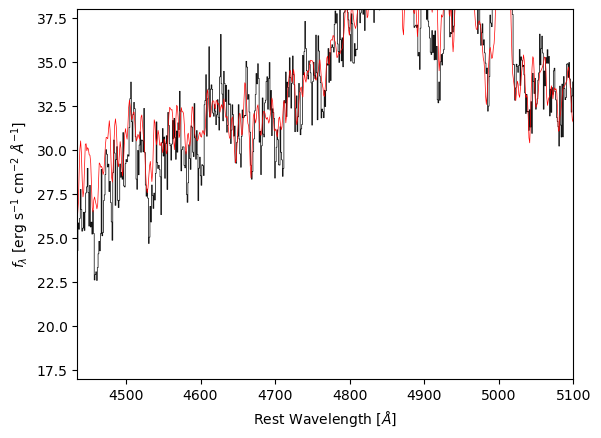

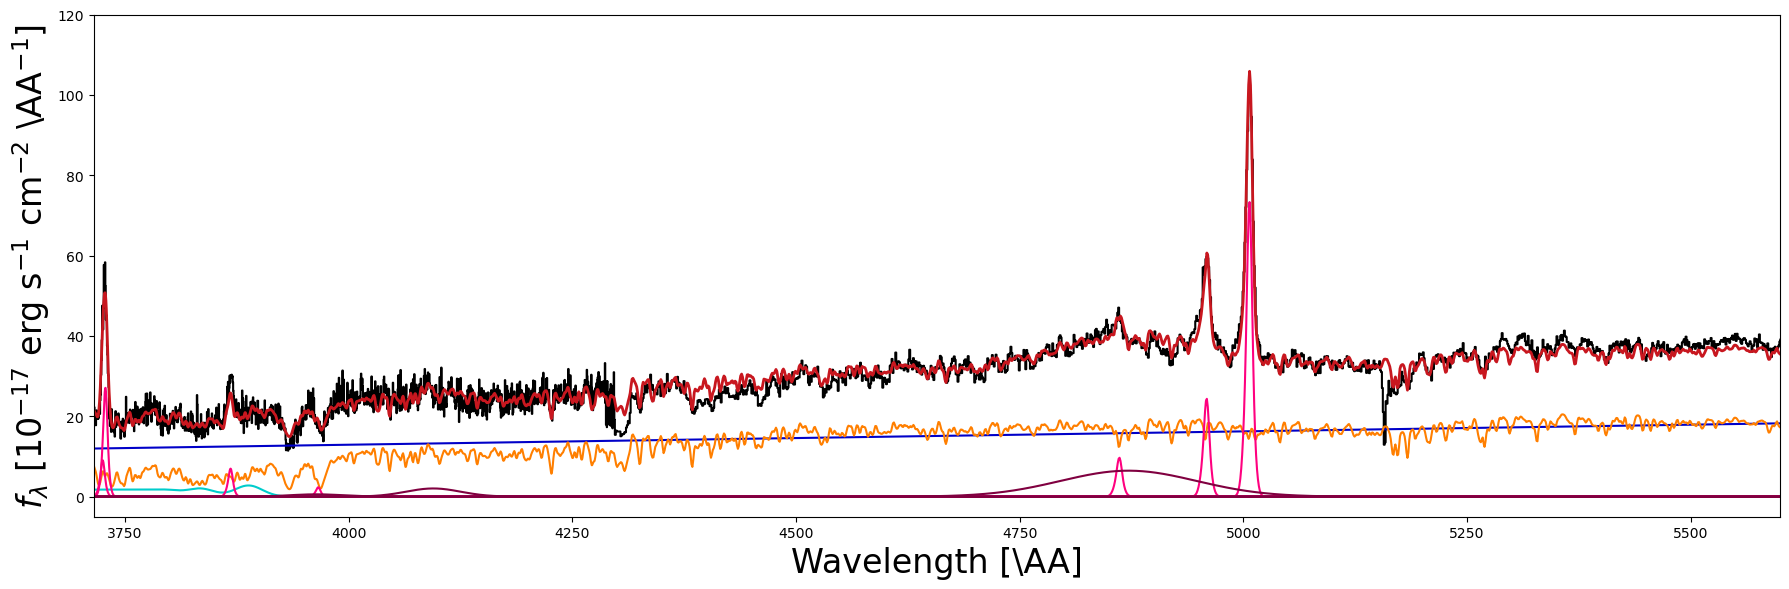

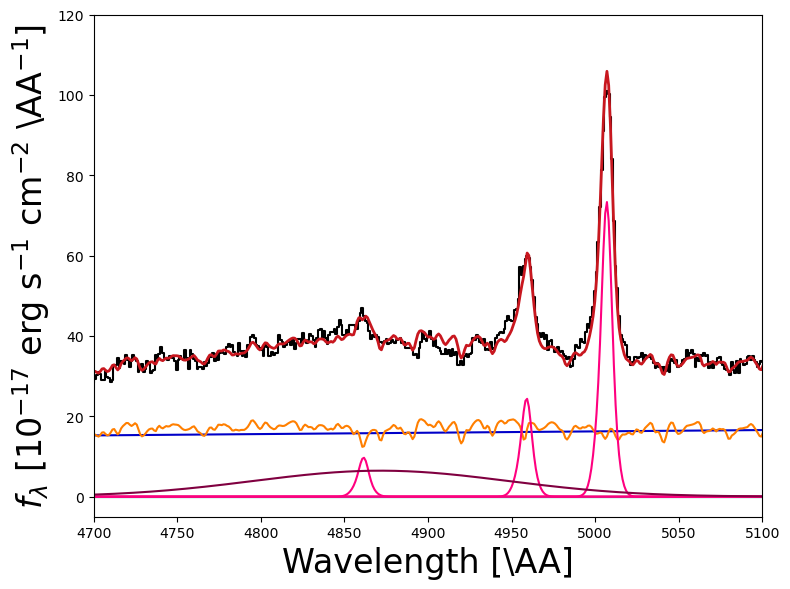

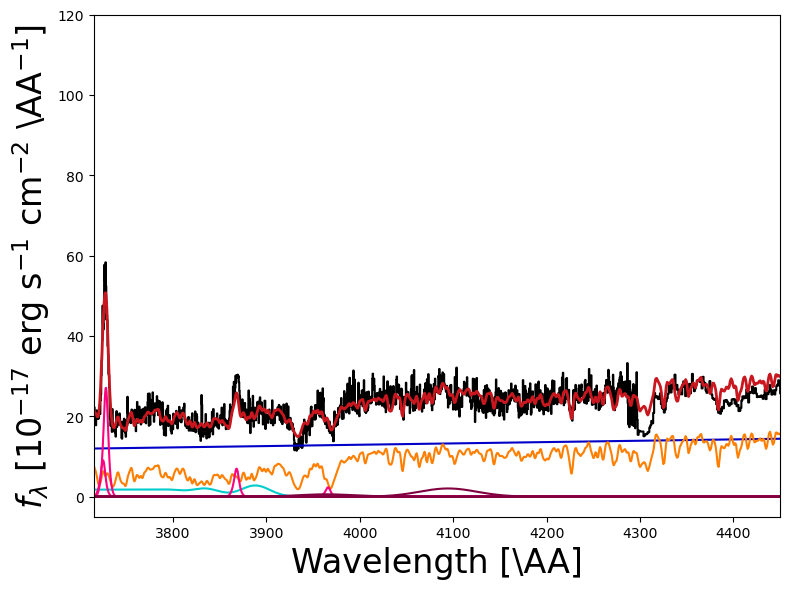

In [37]:
best_model = optical_agn_spectrum(lam,*spec.specfit.parinfo.values,return_components=True)

wavemin = 3725.
wavemax = 5600.
ymin = -2
ymax = 60.
wave = lam
flux = flux
model = best_model
xlabel = 'Wavelength [\AA]'
ylabel = '$f_\lambda$ [10$^{-17}$ erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$]'
plotfile = '../plots/j0950/plots/spec-52509-0902-0498'
HARDCOPY = False
SHOW = True

plot_optical_agn_fit(lam,flux,best_model,3715,5600,-5,120,'Wavelength [\AA]',\
                     '$f_\lambda$ [10$^{-17}$ erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$]',\
                     plotfile,HARDCOPY=False,SHOW=True)

In [38]:
plt.plot(lam,flux,'k-')
plt.xlim([4700,5200])

(4700.0, 5200.0)

In [39]:
#dir(spec.specfit)

spec.specfit.fullmodel
tmp = powerlaw(lam,12.09622924,-0.7281466131)
tmp2 = template_fitter(lam,feii_templates,0.9240725626350278,0.3414985762,0)
#plt.plot(lam,spec.specfit.fullmodel,'k-')
#plt.plot(lam,tmp+tmp2,'r-')


plt.plot(lam,flux,'k',drawstyle='steps-mid')
x = pyspeckit.units.SpectroscopicAxis(lam, unit='Angstrom')
tmp = optical_agn_spectrum(x,40,0.5,5.,40,0.,2.,7,0.,4.,19,0.)
plt.plot(lam,tmp,'r-')

#for i in range(np.shape(spec.specfit.get_components())[0]):
#    plt.plot(lam,spec.specfit.get_components()[i,:],'b')
#plt.plot(lam,spec.specfit.get_components()[0,:],'r')
#plt.plot(lam,spec.specfit.get_components()[1,:],'b')
#plt.plot(lam,spec.specfit.get_components()[10,:],'y')    
#spec.specfit.print_fit() #get model params
#dir(spec.specfit)
#spec.specfit.print_fit()

TypeError: optical_agn_spectrum() missing 90 required positional arguments: 'bh_s', 'bh_index', 'bh_shift', 'o3l1_f', 'o3l1_cent', 'o3l1_fwhm', 'o3l2_f', 'o3l2_cent', 'o3l2_fwhm', 'o3s1_f', 'o3s1_cent', 'o3s1_fwhm', 'o3s2_f', 'o3s2_cent', 'o3s2_fwhm', 'hbn1_f', 'hbn1_cent', 'hbn1_fwhm', 'hbn2_f', 'hbn2_cent', 'hbn2_fwhm', 'hbb1_f', 'hbb1_cent', 'hbb1_fwhm', 'hbb2_f', 'hbb2_cent', 'hbb2_fwhm', 'hbb3_f', 'hbb3_cent', 'hbb3_fwhm', 'hgb1_f', 'hgb1_cent', 'hgb1_fwhm', 'hgb2_f', 'hgb2_cent', 'hgb2_fwhm', 'hdb1_f', 'hdb1_cent', 'hdb1_fwhm', 'hdb2_f', 'hdb2_cent', 'hdb2_fwhm', 'heb1_f', 'heb1_cent', 'heb1_fwhm', 'heb2_f', 'heb2_cent', 'heb2_fwhm', 's21_f', 's21_cent', 's21_fwhm', 's22_f', 's22_cent', 's22_fwhm', 'ne3s1_f', 'ne3s1_cent', 'ne3s1_fwhm', 'ne3s2_f', 'ne3s2_cent', 'ne3s2_fwhm', 'ne3l1_f', 'ne3l1_cent', 'ne3l1_fwhm', 'ne3l2_f', 'ne3l2_cent', 'ne3l2_fwhm', 'o2s1_f', 'o2s1_cent', 'o2s1_fwhm', 'o2s2_f', 'o2s2_cent', 'o2s2_fwhm', 'o2l1_f', 'o2l1_cent', 'o2l1_fwhm', 'o2l2_f', 'o2l2_cent', 'o2l2_fwhm', 'ne5s1_f', 'ne5s1_cent', 'ne5s1_fwhm', 'ne5s2_f', 'ne5s2_cent', 'ne5s2_fwhm', 'ne5l1_f', 'ne5l1_cent', 'ne5l1_fwhm', 'ne5l2_f', 'ne5l2_cent', and 'ne5l2_fwhm'

In [ ]:
dir(spec.specfit)
#spec.specfit.vheight

np.shape(spec.specfit.get_components())

In [ ]:
spec.baseline.subtracted

In [ ]:
x = pyspeckit.units.SpectroscopicAxis(np.linspace(-10,10,50), unit='Angstrom')
dir(x)
x.to_value()

In [ ]:
#spec.plotter(xmin=4400,xmax=5200)

y = spec.plotter.ymax * 0.85
#for i, line in enumerate(spec.measurements.lines.keys()):
#    x = spec.measurements.lines[line]['modelpars'][1]
#    spec.plotter.axis.plot([x]*2, [spec.plotter.ymin.value, spec.plotter.ymax.value], ls = '--', color = 'k')
#    try: spec.plotter.axis.annotate(spec.speclines.optical.lines[line][-1], 
#        (x, y), rotation = 90, ha = 'right', va = 'center')
#    except KeyError: pass

#spec.plotter.axis.set_xlabel(r'Wavelength $(\AA)$')
#spec.plotter.axis.set_ylabel(r'Flux $(10^{-17} \mathrm{erg/s/cm^2/\AA})$')
#
#spec.plotter.refresh()

#dir(spec.speclines.optical.lines.values)
spec.Registry.fitkeys



In [ ]:
def template_fitter(wave,templates,template_vals,scale,param,shift):
        '''
        given a series of templates (like stellar models by age or Fe II templates by convolution width),
        returns a spectrum interpolated between template spectra and scaled.
        Spectrum is also interpolated onto the wavelength vector of the observed data.
        
        params:
            wave - wavelength vector of observed data
            templates - 2D numpy array of shape (numpoints,num_templates+1), where 1st column is wavelength, subsequent columns are templates
            index - selected index within templates [0-num_templates]. Float, will interpolate between templates when index!=int
            scale_factor - multiplicative scale factor for spectrum
        '''
        index = 
        
        num_templates=templates.shape[1]-1
        numpoints=templates.shape[0]
        
        wave_temp=templates[:,0]
        flux_temp=templates[:,1:]
        
        # Perform interpolation between templates
        if index==num_templates-1:
            spectrum=templates[:,-1]
        else:
            lower_idx=int(math.floor(index)+1) #+1 because 0th index is wavelength column
            lower_spectrum=templates[:,lower_idx] # this means lower in index, not necessarily in flux
            
            upper_idx=lower_idx+1
            upper_spectrum=templates[:,upper_idx]
            
            weight=(index+1)-lower_idx #1=choose upper spectrum value, 0=choose lower spectrum value, 0.5=choose midpoint
            
            distances=upper_spectrum-lower_spectrum # array of distances between selected spectra
            
            spectrum=lower_spectrum+(weight*distances)
            
        # Perform scaling
        scaled_spectrum=spectrum*scale_factor
        
        # interpolate spectrum onto wavelength vector of data
        interpfunc = interpolate.interp1d(wave_temp,scaled_spectrum, kind='linear',bounds_error=False,fill_value=0.)
        final_spectrum = interpfunc(wave) 
        
        return final_spectrum

In [ ]:
fe_op = np.genfromtxt('/Users/runnojc1/Software/py/pyqsofit/fe_optical.txt')

In [ ]:
def feii_profile_construction(wave_to_fit,scale,fwhm,shift,single_component_flux=False,
                       return_components=False,
                       return_hyperfine_components=False):

    """
    Computes the optical Fe II from a suite of templates.

    """
    fe_op = np.genfromtxt('/Users/runnojc1/Software/py/pyqsofit/fe_optical.txt')
    feii = fe_flux_optical(wave_to_fit,scale,fwhm,shift)
    
    return feii

In [ ]:
def fe_flux_optical(xval, pp):
    '''
    Fit the optical FeII on the continuum from 3686 to 7484 A based on Vestergaard & Wilkes 2001
    Function modified from PyQSOFit. Input parameters are [scale,fwhm,linear shift].
    '''

    yval = np.zeros_like(xval)
    
    wave_Fe_balmer = 10**fe_op[:, 0]
    flux_Fe_balmer = fe_op[:, 1]*10**15
    ind = np.where((wave_Fe_balmer > 3686.) & (wave_Fe_balmer < 7484.), True, False)
    wave_Fe_balmer = wave_Fe_balmer[ind]
    flux_Fe_balmer = flux_Fe_balmer[ind]
    Fe_FWHM = pp[1]
    xval_new = xval*(1.0+pp[2])
    ind = np.where((xval_new > 3686.) & (xval_new < 7484.), True, False)
    if np.sum(ind) > 100:
        if Fe_FWHM < 900.0:
            sig_conv = np.sqrt(910.0**2-900.0**2)/2./np.sqrt(2.*np.log(2.))
        else:
            sig_conv = np.sqrt(Fe_FWHM**2-900.0**2)/2./np.sqrt(2.*np.log(2.))  # in km/s
        # Get sigma in pixel space
        sig_pix = sig_conv/106.3  # 106.3 km/s is the dispersion for the BG92 FeII template
        khalfsz = np.round(4*sig_pix+1, 0)
        xx = np.arange(0, khalfsz*2, 1)-khalfsz
        kernel = np.exp(-xx**2/(2*sig_pix**2))
        kernel = kernel/np.sum(kernel)
        flux_Fe_conv = np.convolve(flux_Fe_balmer, kernel, 'same')
        tck = interpolate.splrep(wave_Fe_balmer, flux_Fe_conv)
        yval[ind] = pp[0]*interpolate.splev(xval_new[ind], tck)
    return yval

In [ ]:
def feii_profile(wave_to_fit,scale,fwhm,shift):

    """
    Computes the optical Fe II from a suite of templates.

    """
    
    fe_op = np.genfromtxt('/Users/runnojc1/Software/py/pyqsofit/fe_optical.txt')
    pp  = [scale,fwhm,shift]
    feii = fe_flux_optical(wave_to_fit,pp)

    return feii

In [ ]:
def powerlaw(x, scale, power):
    """
    Defines a power law

    Returns
    -------
    scale * (x/1000)**power
    """
    return scale*(x/1000.)**-power

In [ ]:
def optical_agn_spectrum(wave_to_fit,scale):

    """
    Computes a model for the optical spectrum.

    """
    
    #fe_op = np.genfromtxt('/Users/runnojc1/Software/py/pyqsofit/fe_optical.txt')
    #pp  = [scale,fwhm,shift]
    #feii = fe_flux_optical(wave_to_fit,pp)
    #spec = feii
    
    #pl = powerlaw(wave_to_fit,pls,ple)
    #spec = spec + pl
    
    #fe_op = np.genfromtxt('/Users/runnojc1/Software/py/pyqsofit/fe_optical.txt')
    #pp  = [scale,fwhm,shift]
    #feii = fe_flux_optical(wave_to_fit,pp)
    spec = np.zeros_like(wave_to_fit)
    spec = spec+scale
    
    return spec

In [ ]:
def optical_agn_fitter():

  """
  Generator for optical AGN

  """
  #myclass =  pyspeckit.models.model.SpectralModel(optical_spectrum,
  #        5,
  #        parnames=['pls','ple','scale','fwhm','shift'],
  #        parlimited=[(False,False),(False,False),(False,False),(False,False),(False,False)],
  #        parlimits=[(0,1e6),(-5,5),(0,1e6),(0,1e5),(-10,10)])
  #myclass.__name__ = "optagn"
  myclass =  pyspeckit.models.model.SpectralModel(optical_agn_spectrum,
          1,
          parnames=['scale'],
          parlimited=[(False,False)],
          parlimits=[(0,0)],fitunit=None)
  myclass.__name__ = "optqso"

  return myclass

In [ ]:
def feii_fitter():

  """
  Generator for Fe II template

  """
  myclass =  pyspeckit.models.model.SpectralModel(feii_profile,
          3,
          parnames=['scale','fwhm','shift'],
          parlimited=[(False,False),(False,False),(False,False)],
          parlimits=[(0,1e6),(0,1e5),(-10,10)])
  myclass.__name__ = "feii"

  return myclass

In [ ]:
pp  = [1.,4000.,0.]
feii = fe_flux_optical(lam,pp)

tmp = optical_agn_spectrum(lam,20)

plt.plot(lam,tmp,'k-')

In [ ]:
spec.Registry.add_fitter('feii',feii_fitter(),3)

In [ ]:
dir(spec.Registry)

In [ ]:
spec.Registry.multifitters

In [ ]:
spec.Registry.fitkeys

In [ ]:
spec = pyspeckit.Spectrum(data=flux,xarr=lam, error=err_unred,header={})
spec.unit = 'erg s$^{-1}$ cm$^{-2}$ $\\AA^{-1}$'
spec.xarr.set_unit = u.angstrom #'$\\AA$'
spec.xarr.xtype='angstrom'
#spec.Registry.add_fitter('optagn',optical_spectrum_fitter(),5)
spec.Registry.add_fitter('feii',feii_fitter(),3)
spec.specfit(fittype='feii',guesses=[1,4000,0.],quiet=False, fixed=[False,False,False])


## FOR NEXT WEEK: FIGURE OUT HOW TO FIT THE FEII TEMPLATE AND GAUSSIANS AND A POWERLAW

In [ ]:
spec.plotter(xmin=4400,xmax=5200,ymin=-2,ymax=60,xlabel='Rest Wavelength [$\AA$]',ylabel="$f_{\lambda}$ [erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]")
spec.specfit.plot_fit(annotate=False)
#spec.specfit.plot_components()

In [ ]:
spec = pyspeckit.Spectrum(data=flux,xarr=lam, error=err_unred,header={})

spec.specfit.Registry.multifitters

In [ ]:
spec.specfit.parinfo.values
#spec.specfit.parinfo.errors
#reduced_chi2 = spec.specfit.chi2/spec.specfit.dof